Read and Divide Data

In [ ]:
# The Prostate data set can be found here: 
# The Real Estate CSV can be found here: www.kaggle.com/datasets/quantbruce/real-estate-price-prediction

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as LinearModel

# function that cleans and preprocesses the data for the prostate dataset
def clean_data():
  data = pd.read_csv("./prostate.data", '\t').sample(frac=1)
  data = data.drop(columns=data.columns[0]).drop(columns=data.columns[-1:])
  features = data.drop(columns=data.columns[-1:])
  features = (features - features.mean())/features.std()

  labels = data.drop(columns=data.columns[:-1])
  
  # create dividers with to make a 80 10 10 split
  dividers = [int(len(data) * 0.8), int(len(data) * 0.8) + int(len(data) * 0.1) + 1]


  training_features = features[0:dividers[0]]
  training_labels = labels[0:dividers[0]]

  testing_features = features[dividers[0]:dividers[1]]
  testing_labels = labels[dividers[0]:dividers[1]]

  validation_features = features[dividers[1]:len(data)]
  validation_labels = labels[dividers[1]:len(data)]

  columns = validation_features.columns

  training_features.insert(0, "intercept", np.ones(len(training_features)))
  testing_features.insert(0, "intercept", np.ones(len(testing_features)))
  validation_features.insert(0, "intercept", np.ones(len(validation_features)))
  
  training_features = training_features.to_numpy()
  testing_features = testing_features.to_numpy()
  validation_features = validation_features.to_numpy()

  training_labels = training_labels.to_numpy()
  testing_labels = testing_labels.to_numpy()
  validation_labels = validation_labels.to_numpy()

  return training_features, training_labels, testing_features, testing_labels, validation_features, validation_labels, columns

# function that cleans and preprocesses the data for the real estate dataset
# This dataset was taken from www.kaggle.com/datasets/quantbruce/real-estate-price-prediction
def clean_data2():
  data = pd.read_csv("./Real estate.csv").sample(frac=1)
  data = data.drop(columns=data.columns[0])

  features = data.drop(columns=data.columns[-1:])
  features = (features - features.mean())/features.std()

  labels = data.drop(columns=data.columns[:-1])
  
  dividers = [int(len(data) * 0.8), int(len(data) * 0.8) + int(len(data) * 0.1) + 1]


  training_features = features[0:dividers[0]]
  training_labels = labels[0:dividers[0]]

  testing_features = features[dividers[0]:dividers[1]]
  testing_labels = labels[dividers[0]:dividers[1]]

  validation_features = features[dividers[1]:len(data)]
  validation_labels = labels[dividers[1]:len(data)]
  columns = validation_features.columns

  training_features.insert(0, "intercept", np.ones(len(training_features)))
  testing_features.insert(0, "intercept", np.ones(len(testing_features)))
  validation_features.insert(0, "intercept", np.ones(len(validation_features)))
  
  training_features = training_features.to_numpy()
  testing_features = testing_features.to_numpy()
  validation_features = validation_features.to_numpy()

  training_labels = training_labels.to_numpy()
  testing_labels = testing_labels.to_numpy()
  validation_labels = validation_labels.to_numpy()
  print(training_features)

  return training_features, training_labels, testing_features, testing_labels, validation_features, validation_labels, columns


def linear_regression(x, y):
  # equation 3.6: b_h = (X^T * X)^-1 * X^T * y
  b_h = np.linalg.inv(x.T @ x) @ x.T @ y
  return b_h

def linear_ridge_regression(x, y, lam):
  # equation 3.6: b_h = (X^T * X)^-1 * X^T * y
  b_h = np.linalg.inv(x.T @ x + lam * np.identity(x.shape[1])) @ x.T @ y
  b_o = np.mean(y)
  return b_o, b_h

def prediction(x, b):
  return x @ b

def prediction_ridge_regression(x, b, b_o):
  return b_o + x @ b

def MSE(y, y_h):
  return np.mean(np.square((y - y_h)))

def std_err(x, y, y_hat):
  stde = np.sqrt((1 / (x.shape[0] - x.shape[1] - 1 ) * np.sum(np.square(y-y_hat))) * np.diagonal(np.linalg.inv(x.T @ x)))
  return np.array([stde]).T

Print Tables

In [ ]:
def Tables(data_name,training_features, training_labels, testing_features, testing_labels, columns):
  print("-----------------------------------------------------------------")
  print("Linear Regression for " + data_name)
  print("------------------------------")

  b_h = linear_regression(training_features, training_labels)
  y_h_train = prediction(training_features, b_h)
  y_h_test = prediction(testing_features, b_h)
  # generating correlation table
  print("TABLE 3.1. Correlations of predictors in the " + data_name + " data.")
  print(pd.DataFrame(training_features[:,1:], columns=[columns]).corr())
  print("------------------------------")

  # generating linear model fit
  print("TABLE 3.2. Linear model fit to the " + data_name + " data.")
  var = np.linalg.inv(np.dot(training_features.transpose(), training_features))

  linear_model_df = pd.DataFrame()
  linear_model_df['Term'] = ["intercept"] + list(columns)
  linear_model_df['Coefficient'] = b_h
  linear_model_df['Std Error'] = std_err(training_features, training_labels, y_h_train)
  linear_model_df['Z Score'] = b_h / std_err(training_features, training_labels, y_h_train)

  display(linear_model_df)
  display("MSE= " + str(MSE(testing_labels, y_h_test)))


Ridge Regression

In [ ]:
def Ridge(data_name, training_features, training_labels, testing_features, testing_labels, validation_features, validation_labels, columns):
  print("-----------------------------------------------------------------")
  print("Ridge Regression for " + data_name)
  print("------------------------------")
  
  num_lambdas = 1000
  test_lams = np.linspace(1, 1000, num_lambdas)

  min_mse = 1e12

  best_lam = 0
  best_b_o = 0
  best_b_h = 0
  bs = np.zeros((training_features.shape[1] - 1, num_lambdas))

  for i, lam in enumerate(test_lams):
    b_o, b_h = linear_ridge_regression(training_features[:, 1:], training_labels, lam)
    y_h = prediction_ridge_regression(validation_features[:, 1:], b_h, b_o)
    mse = MSE(validation_labels, y_h).item()
    #print(mse)
    bs[:, i] = b_h.flatten().T
    if mse < min_mse:
      min_mse = mse
      best_lam = lam
      best_b_o = b_o
      best_b_h = b_h

  print("best lambda= " + str(best_lam))
  print("min mse = " + str(min_mse))
  fig, ax = plt.subplots(1, 1)
  ax.plot(np.log(test_lams), bs.T)
  ax.legend(columns)
  ax.axvline(np.log(best_lam), ls="--")
  ax.invert_xaxis()
  ax.set_xlabel("Lambda")
  ax.set_ylabel("coef")
  ax.set_title("Ridge Regression for " + data_name)

  y_h = prediction_ridge_regression(testing_features[:, 1:], best_b_h, best_b_o)
  display("Test MSE = " + str(MSE(testing_labels, y_h)))

Lasso Regression

In [ ]:
def Lasso(data_name, training_features, training_labels, validation_features, validation_labels, columns, start_lam=0.0001, end_lam=1):
  print("-----------------------------------------------------------------")
  print("Lasso for " + data_name)
  print("------------------------------")
  
  num_lambdas = 1000
  test_lams2 = np.linspace(start_lam, end_lam, num_lambdas)

  best_score = 0
  best_lambda = 0
  bs = np.zeros((training_features.shape[1] - 1, num_lambdas))

  for i, lam in enumerate(test_lams2):
    lasso = LinearModel.Lasso(alpha=lam)
    lasso.fit(list(training_features[:, 1:]), list(training_labels))
    score = lasso.score(validation_features[:, 1:], validation_labels)
    bs[:, i] = lasso.coef_
    if score > best_score:
      best_score = score
      best_lambda = lam

  print("Best Lamba= "  + str(best_lambda))
  fig, ax = plt.subplots(1, 1)
  ax.axvline(best_lambda, ls="--")
  ax.plot(test_lams2, bs.T)
  ax.invert_xaxis()
  ax.legend(columns)
  ax.set_xlabel("Lambda")
  ax.set_ylabel("coef")
  ax.set_title("Ridge Regression for " + data_name)

-----------------------------------------------------------------
Linear Regression for Prostate Cancer
------------------------------
TABLE 3.1. Correlations of predictors in the Prostate Cancer data.
           lcavol   lweight       age      lbph       svi       lcp   gleason  \
lcavol   1.000000  0.268272  0.290181  0.071561  0.467667  0.655806  0.438743   
lweight  0.268272  1.000000  0.363626  0.494353  0.104236  0.133239  0.029366   
age      0.290181  0.363626  1.000000  0.352121  0.147517  0.141371  0.252320   
lbph     0.071561  0.494353  0.352121  1.000000 -0.066412  0.038019  0.076753   
svi      0.467667  0.104236  0.147517 -0.066412  1.000000  0.673916  0.260707   
lcp      0.655806  0.133239  0.141371  0.038019  0.673916  1.000000  0.489157   
gleason  0.438743  0.029366  0.252320  0.076753  0.260707  0.489157  1.000000   
pgg45    0.444625  0.034162  0.241415  0.091742  0.484052  0.629307  0.738703   

            pgg45  
lcavol   0.444625  
lweight  0.034162  
age     

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  """Entry point for launching an IPython kernel.


,Term,Coefficient,Std Error,Z Score
0,intercept,2.557721,0.080358,31.829140
1,lcavol,0.673562,0.116991,5.757365
2,lweight,0.276025,0.099553,2.772639
3,age,-0.103831,0.093798,-1.106963
4,lbph,0.126789,0.097487,1.300572
5,svi,0.274236,0.122436,2.239835
6,lcp,-0.106328,0.145702,-0.729763
7,gleason,-0.036245,0.124057,-0.292160
8,pgg45,0.211098,0.142635,1.479988


'MSE= 0.6698503474388362'

-----------------------------------------------------------------
Ridge Regression for Prostate Cancer
------------------------------
best lambda= 1.0
min mse = 0.5352473669025946


'Test MSE = 0.6493524952778619'

-----------------------------------------------------------------
Lasso for Prostate Cancer
------------------------------
Best Lamba= 0.2243018018018018


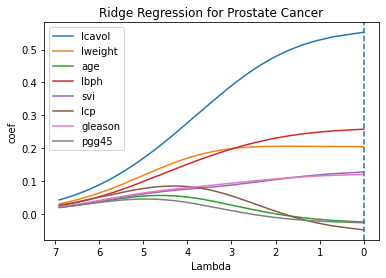

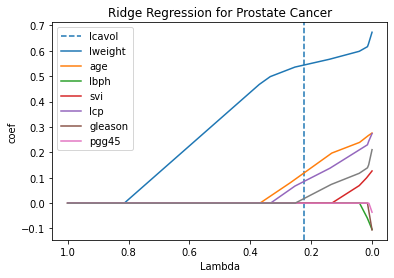

In [ ]:
training_features, training_labels, testing_features, testing_labels, validation_features, validation_labels, columns = clean_data()
columns1 = ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']

Tables("Prostate Cancer", training_features, training_labels, testing_features, testing_labels,columns1)
Ridge("Prostate Cancer",training_features, training_labels, testing_features, testing_labels, validation_features, validation_labels, columns1)
Lasso("Prostate Cancer",training_features, training_labels, validation_features, validation_labels, columns1)

[[ 1.          0.95056782  1.21022237 ... -1.05046273 -1.45687237
  -3.17850429]
 [ 1.          0.95056782  1.5437756  ...  0.98650013  0.81384106
   0.21495235]
 [ 1.         -0.23396695 -0.58920952 ... -0.71096892 -0.39564824
  -1.08561206]
 ...
 [ 1.         -1.12059477 -1.55475834 ... -1.38995654  0.16679249
  -0.108234  ]
 [ 1.         -0.52832738  0.44656103 ... -0.71096892  0.9645236
   0.89716224]
 [ 1.          1.24492826 -0.33465574 ... -1.38995654  3.67116888
  -0.9904806 ]]
-----------------------------------------------------------------
Linear Regression for Real Estate
------------------------------
TABLE 3.1. Correlations of predictors in the Real Estate data.
                     date house age distance to MRT num_conv_store       lat  \
date             1.000000  0.001976        0.046967       0.053705  0.062133   
house age        0.001976  1.000000        0.061883       0.058334  0.050811   
distance to MRT  0.046967  0.061883        1.000000      -0.605944 -0.60003

,Term,Coefficient,Std Error,Z Score
0,intercept,38.081859,0.498326,76.419561
1,date,1.617701,0.504709,3.205212
2,house age,-3.485885,0.509325,-6.844133
3,distance to MRT,-5.588852,1.044831,-5.349050
4,num_conv_store,3.077577,0.627806,4.902115
5,lat,2.862331,0.620240,4.614880
6,long,-0.381247,0.871051,-0.437687


'MSE= 77.16692416473232'

-----------------------------------------------------------------
Ridge Regression for Real Estate
------------------------------
best lambda= 135.0
min mse = 57.43566062707578


'Test MSE = 83.52945705708377'

-----------------------------------------------------------------
Lasso for Real Estate
------------------------------
Best Lamba= 1.6817144144144143


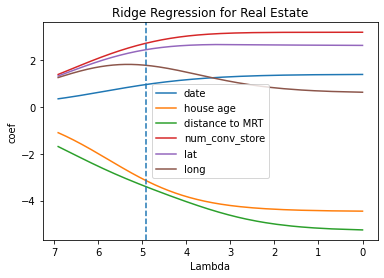

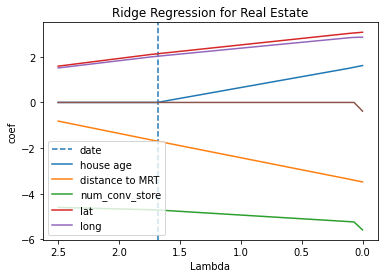

In [ ]:
training_features2, training_labels2, testing_features2, testing_labels2, validation_features2, validation_labels2, columns2 = clean_data2()
columns2 = ['date', 'house age', 'distance to MRT', 'num_conv_store', 'lat', 'long']

Tables("Real Estate", training_features2, training_labels2, testing_features2, testing_labels2, columns2)
Ridge("Real Estate",training_features2, training_labels2, testing_features2, testing_labels2, validation_features2, validation_labels2, columns2)
Lasso("Real Estate",training_features2, training_labels2, validation_features2, validation_labels2, columns2, 0.0001, 2.5)

For the real estate dataset, it looks like the latitude, longitude, and house age matter most. This makes sense, as location is highly correlated to house prices, and newer houses are typically more expensive than older ones.

